In [1]:
# import librairies
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import math as math
import time 
import surprise
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import pytorch_lightning as pl
import plotly.express as px
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
plt.style.use('seaborn')
plt.rcParams['figure.figsize'] = [14,14]
from surprise import Dataset
from surprise import accuracy
from surprise import Reader
from surprise.model_selection import cross_validate
from surprise.model_selection import train_test_split
from surprise import Reader, Dataset, SVD
import community
import seaborn as sns
from scipy import stats
from ast import literal_eval
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import wordnet

import warnings; warnings.simplefilter('ignore')

In [2]:
pd.set_option('display.max_columns', 500)

In [3]:
md = pd.read_csv('./data/movies-dataset/movies_metadata.csv',parse_dates=['release_date'])
credits = pd.read_csv('./data/movies-dataset/credits.csv')
keywords = pd.read_csv('./data/movies-dataset/keywords.csv')
links = pd.read_csv('./data/movies-dataset/links.csv')
links_small = pd.read_csv('./data/movies-dataset/links_small.csv')
ratings = pd.read_csv('./data/movies-dataset/ratings.csv', parse_dates=['timestamp'])
ratings_small = pd.read_csv('./data/movies-dataset/ratings_small.csv')

# EDA

In [4]:
md.head()

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.9469,/rhIRbceoE9lR4veEXuwCC2wARtG.jpg,"[{'name': 'Pixar Animation Studios', 'id': 3}]","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,17.0155,/vzmL6fP7aPKNKPRTFnZmiUfciyV.jpg,"[{'name': 'TriStar Pictures', 'id': 559}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,11.7129,/6ksm1sjKMFLbO7UY2i6G1ju9SML.jpg,"[{'name': 'Warner Bros.', 'id': 6194}, {'name'...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",3.85949,/16XOMpEaLWkrcPqSQqhTmeJuqQl.jpg,[{'name': 'Twentieth Century Fox Film Corporat...,"[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,8.38752,/e64sOI48hQXyru7naBFyssKFxVd.jpg,"[{'name': 'Sandollar Productions', 'id': 5842}...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0


In [5]:
credits.head()

,cast,crew,id
0,"[{'cast_id': 14, 'character': 'Woody (voice)',...","[{'credit_id': '52fe4284c3a36847f8024f49', 'de...",862
1,"[{'cast_id': 1, 'character': 'Alan Parrish', '...","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de...",8844
2,"[{'cast_id': 2, 'character': 'Max Goldman', 'c...","[{'credit_id': '52fe466a9251416c75077a89', 'de...",15602
3,"[{'cast_id': 1, 'character': ""Savannah 'Vannah...","[{'credit_id': '52fe44779251416c91011acb', 'de...",31357
4,"[{'cast_id': 1, 'character': 'George Banks', '...","[{'credit_id': '52fe44959251416c75039ed7', 'de...",11862


In [6]:
keywords.head()

,id,keywords
0,862,"[{'id': 931, 'name': 'jealousy'}, {'id': 4290,..."
1,8844,"[{'id': 10090, 'name': 'board game'}, {'id': 1..."
2,15602,"[{'id': 1495, 'name': 'fishing'}, {'id': 12392..."
3,31357,"[{'id': 818, 'name': 'based on novel'}, {'id':..."
4,11862,"[{'id': 1009, 'name': 'baby'}, {'id': 1599, 'n..."


In [7]:
links.head()

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


In [8]:
links_small.head()

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


In [9]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,110,1.0,1425941529
1,1,147,4.5,1425942435
2,1,858,5.0,1425941523
3,1,1221,5.0,1425941546
4,1,1246,5.0,1425941556


In [10]:
ratings_small.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


# Popularity Recommendation

In [11]:
md.head()

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.9469,/rhIRbceoE9lR4veEXuwCC2wARtG.jpg,"[{'name': 'Pixar Animation Studios', 'id': 3}]","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,17.0155,/vzmL6fP7aPKNKPRTFnZmiUfciyV.jpg,"[{'name': 'TriStar Pictures', 'id': 559}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,11.7129,/6ksm1sjKMFLbO7UY2i6G1ju9SML.jpg,"[{'name': 'Warner Bros.', 'id': 6194}, {'name'...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",3.85949,/16XOMpEaLWkrcPqSQqhTmeJuqQl.jpg,[{'name': 'Twentieth Century Fox Film Corporat...,"[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,8.38752,/e64sOI48hQXyru7naBFyssKFxVd.jpg,"[{'name': 'Sandollar Productions', 'id': 5842}...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0


In [12]:
md['genres'] = md['genres'].fillna('[]').apply(literal_eval).apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])
md['year'] = pd.to_datetime(md['release_date'], errors='coerce').apply(lambda x: str(x).split('-')[0] if x != np.nan else np.nan)
vote_counts = md[md['vote_count'].notnull()]['vote_count'].astype('int')
vote_averages = md[md['vote_average'].notnull()]['vote_average'].astype('int')
C = vote_averages.mean()
C

5.244896612406511

In [13]:
m = vote_counts.quantile(0.95)
m

434.0

In [14]:
qualified = md[(md['vote_count'] >= m) & (md['vote_count'].notnull()) & (md['vote_average'].notnull())][['title', 'year', 'vote_count', 'vote_average', 'popularity', 'genres']]
qualified['vote_count'] = qualified['vote_count'].astype('int')
qualified['vote_average'] = qualified['vote_average'].astype('int')
qualified.shape

(2274, 6)

In [15]:
def weighted_rating(x):
    v = x['vote_count']
    R = x['vote_average']
    return (v/(v+m) * R) + (m/(m+v) * C)

In [16]:
qualified['wr'] = qualified.apply(weighted_rating, axis=1)

In [17]:
qualified = qualified.sort_values('wr', ascending=False).head(250)

In [18]:
qualified.head(15)

,title,year,vote_count,vote_average,popularity,genres,wr
15480,Inception,2010,14075,8,29.1081,"[Action, Thriller, Science Fiction, Mystery, A...",7.917588
12481,The Dark Knight,2008,12269,8,123.167,"[Drama, Action, Crime, Thriller]",7.905871
22879,Interstellar,2014,11187,8,32.2135,"[Adventure, Drama, Science Fiction]",7.897107
2843,Fight Club,1999,9678,8,63.8696,[Drama],7.881753
4863,The Lord of the Rings: The Fellowship of the Ring,2001,8892,8,32.0707,"[Adventure, Fantasy, Action]",7.871787
292,Pulp Fiction,1994,8670,8,140.95,"[Thriller, Crime]",7.868660
314,The Shawshank Redemption,1994,8358,8,51.6454,"[Drama, Crime]",7.864000
7000,The Lord of the Rings: The Return of the King,2003,8226,8,29.3244,"[Adventure, Fantasy, Action]",7.861927
351,Forrest Gump,1994,8147,8,48.3072,"[Comedy, Drama, Romance]",7.860656
5814,The Lord of the Rings: The Two Towers,2002,7641,8,29.4235,"[Adventure, Fantasy, Action]",7.851924


In [19]:
s = md.apply(lambda x: pd.Series(x['genres']),axis=1).stack().reset_index(level=1, drop=True)
s.name = 'genre'
gen_md = md.drop('genres', axis=1).join(s)

In [20]:
def build_chart(genre, percentile=0.85):
    df = gen_md[gen_md['genre'] == genre]
    vote_counts = df[df['vote_count'].notnull()]['vote_count'].astype('int')
    vote_averages = df[df['vote_average'].notnull()]['vote_average'].astype('int')
    C = vote_averages.mean()
    m = vote_counts.quantile(percentile)
    
    qualified = df[(df['vote_count'] >= m) & (df['vote_count'].notnull()) & (df['vote_average'].notnull())][['title', 'year', 'vote_count', 'vote_average', 'popularity']]
    qualified['vote_count'] = qualified['vote_count'].astype('int')
    qualified['vote_average'] = qualified['vote_average'].astype('int')
    
    qualified['wr'] = qualified.apply(lambda x: (x['vote_count']/(x['vote_count']+m) * x['vote_average']) + (m/(m+x['vote_count']) * C), axis=1)
    qualified = qualified.sort_values('wr', ascending=False).head(250)
    
    return qualified

In [21]:
list(md.loc[md['title'] == 'Avatar']['genres'])

[['Action', 'Adventure', 'Fantasy', 'Science Fiction']]

In [22]:
build_chart('Adventure').sort_values('year',ascending=False).head(15)

,title,year,vote_count,vote_average,popularity,wr
33356,Wonder Woman,2017,5025,7,294.337037,6.843816
26566,Guardians of the Galaxy Vol. 2,2017,4858,7,185.331,6.838948
42171,Kong: Skull Island,2017,3161,6,29.429112,5.900741
26560,Pirates of the Caribbean: Dead Men Tell No Tales,2017,2814,6,133.828,5.890346
41488,The Space Between Us,2017,564,7,11.824404,6.188681
43645,Okja,2017,795,7,15.738471,6.333459
39463,Nerve,2016,2262,7,14.9837,6.687547
41457,Moana,2016,3471,7,9.143457,6.782688
38176,Finding Dory,2016,4333,6,14.477677,5.924814
41536,Passengers,2016,4134,6,20.303632,5.921585


# Content Based Recommendation

In [23]:
links_small = pd.read_csv('./data/movies-dataset/links_small.csv')
links_small = links_small[links_small['tmdbId'].notnull()]['tmdbId'].astype('int')
links_small.head()

0      862
1     8844
2    15602
3    31357
4    11862
Name: tmdbId, dtype: int64

In [24]:
md = md.drop([19730, 29503, 35587])

In [25]:
#Check EDA Notebook for how and why I got these indices.
md['id'] = md['id'].astype('int')

In [26]:
smd = md[md['id'].isin(links_small)]
smd.shape

(9099, 25)

In [27]:
smd['tagline'] = smd['tagline'].fillna('')
smd['description'] = smd['overview'] + smd['tagline']
smd['description'] = smd['description'].fillna('')

In [28]:
tf = TfidfVectorizer(analyzer='word',ngram_range=(1, 2),min_df=0, stop_words='english')
tfidf_matrix = tf.fit_transform(smd['description'])

In [29]:
tfidf_matrix.shape

(9099, 268124)

In [30]:
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

In [31]:
cosine_sim[0]

array([1.        , 0.00680476, 0.        , ..., 0.        , 0.00344913,
       0.        ])

In [32]:
smd = smd.reset_index()
titles = smd['title']
indices = pd.Series(smd.index, index=smd['title'])

In [33]:
def get_recommendations(title):
    idx = indices[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:31]
    movie_indices = [i[0] for i in sim_scores]
    return titles.iloc[movie_indices]

In [34]:
get_recommendations('Avatar').head(10)

2059                                    The Matrix
4506                              Tears of the Sun
4695    Lara Croft Tomb Raider: The Cradle of Life
2910               Pandora and the Flying Dutchman
538                          Hellraiser: Bloodline
7460                                    Green Zone
7587                                  The American
3015                                 House Party 2
2561                                     Supernova
975                                A Grand Day Out
Name: title, dtype: object

In [35]:
get_recommendations('Inception').head(10)

5239                              Cypher
141                                Crumb
6398                         Renaissance
653                            Lone Star
1703                               House
4739                    The Pink Panther
319                                 Cobb
2828    What Ever Happened to Baby Jane?
8867                     Pitch Perfect 2
979          Once Upon a Time in America
Name: title, dtype: object

### Metadata based Recommender

In [36]:
credits = pd.read_csv('./data/movies-dataset/credits.csv')
keywords = pd.read_csv('./data/movies-dataset/keywords.csv')

In [37]:
keywords['id'] = keywords['id'].astype('int')
credits['id'] = credits['id'].astype('int')
md['id'] = md['id'].astype('int')

In [38]:
md.shape

(45463, 25)

In [39]:
md = md.merge(credits, on='id')
md = md.merge(keywords, on='id')

In [40]:
smd = md[md['id'].isin(links_small)]
smd.shape

(9219, 28)

In [41]:
smd['cast'] = smd['cast'].apply(literal_eval)
smd['crew'] = smd['crew'].apply(literal_eval)
smd['keywords'] = smd['keywords'].apply(literal_eval)
smd['cast_size'] = smd['cast'].apply(lambda x: len(x))
smd['crew_size'] = smd['crew'].apply(lambda x: len(x))

In [42]:
def get_director(x):
    for i in x:
        if i['job'] == 'Director':
            return i['name']
    return np.nan

In [43]:
smd['director'] = smd['crew'].apply(get_director)

In [44]:
smd['cast'] = smd['cast'].apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])
smd['cast'] = smd['cast'].apply(lambda x: x[:3] if len(x) >=3 else x)

In [45]:
smd['keywords'] = smd['keywords'].apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])

In [46]:
smd['cast'] = smd['cast'].apply(lambda x: [str.lower(i.replace(" ", "")) for i in x])

In [47]:
smd['director'] = smd['director'].astype('str').apply(lambda x: str.lower(x.replace(" ", "")))
smd['director'] = smd['director'].apply(lambda x: [x,x, x])

In [48]:
s = smd.apply(lambda x: pd.Series(x['keywords']),axis=1).stack().reset_index(level=1, drop=True)
s.name = 'keyword'

In [49]:
s = s.value_counts()
s[:5]

independent film        610
woman director          550
murder                  399
duringcreditsstinger    327
based on novel          318
Name: keyword, dtype: int64

In [50]:
s = s[s > 1]

In [51]:
stemmer = SnowballStemmer('english')
stemmer.stem('dogs')

'dog'

In [52]:
def filter_keywords(x):
    words = []
    for i in x:
        if i in s:
            words.append(i)
    return words

In [53]:
smd['keywords'] = smd['keywords'].apply(filter_keywords)
smd['keywords'] = smd['keywords'].apply(lambda x: [stemmer.stem(i) for i in x])
smd['keywords'] = smd['keywords'].apply(lambda x: [str.lower(i.replace(" ", "")) for i in x])

In [54]:
smd['soup'] = smd['keywords'] + smd['cast'] + smd['director'] + smd['genres']
smd['soup'] = smd['soup'].apply(lambda x: ' '.join(x))

In [55]:
count = CountVectorizer(analyzer='word',ngram_range=(1, 2),min_df=0, stop_words='english')
count_matrix = count.fit_transform(smd['soup'])

In [56]:
cosine_sim = cosine_similarity(count_matrix, count_matrix)

In [57]:
smd = smd.reset_index()
titles = smd['title']
indices = pd.Series(smd.index, index=smd['title'])

In [58]:
get_recommendations('Avatar').head(10)

974                             Aliens
522         Terminator 2: Judgment Day
1011                    The Terminator
922                          The Abyss
4347    Piranha Part Two: The Spawning
344                          True Lies
1376                           Titanic
8401           Star Trek Into Darkness
3216                Dungeons & Dragons
8724                 Jupiter Ascending
Name: title, dtype: object

In [59]:
get_recommendations('Inception').head(10)

6623                             The Prestige
3381                                  Memento
4145                                 Insomnia
2085                                Following
8031                    The Dark Knight Rises
8613                             Interstellar
6981                          The Dark Knight
6218                            Batman Begins
5638    Sky Captain and the World of Tomorrow
8500                                  Don Jon
Name: title, dtype: object

In [60]:
def improved_recommendations(title):
    idx = indices[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:26]
    movie_indices = [i[0] for i in sim_scores]
    
    movies = smd.iloc[movie_indices][['title', 'vote_count', 'vote_average', 'year']]
    vote_counts = movies[movies['vote_count'].notnull()]['vote_count'].astype('int')
    vote_averages = movies[movies['vote_average'].notnull()]['vote_average'].astype('int')
    C = vote_averages.mean()
    m = vote_counts.quantile(0.60)
    qualified = movies[(movies['vote_count'] >= m) & (movies['vote_count'].notnull()) & (movies['vote_average'].notnull())]
    qualified['vote_count'] = qualified['vote_count'].astype('int')
    qualified['vote_average'] = qualified['vote_average'].astype('int')
    qualified['wr'] = qualified.apply(weighted_rating, axis=1)
    qualified = qualified.sort_values('wr', ascending=False).head(10)
    return qualified

In [61]:
improved_recommendations('Avatar')

,title,vote_count,vote_average,year,wr
1376,Titanic,7770,7,1997,6.907153
8658,X-Men: Days of Future Past,6155,7,2014,6.884396
8401,Star Trek Into Darkness,4479,7,2013,6.844959
522,Terminator 2: Judgment Day,4274,7,1991,6.838208
1011,The Terminator,4208,7,1984,6.835908
974,Aliens,3282,7,1986,6.795018
922,The Abyss,822,7,1989,6.393539
8419,Man of Steel,6462,6,2013,5.952478
344,True Lies,1138,6,1994,5.791530
8724,Jupiter Ascending,2816,5,2015,5.032703


In [62]:
improved_recommendations('Inception')

,title,vote_count,vote_average,year,wr
6981,The Dark Knight,12269,8,2008,7.905871
8613,Interstellar,11187,8,2014,7.897107
6623,The Prestige,4510,8,2006,7.758148
3381,Memento,4168,8,2000,7.740175
8031,The Dark Knight Rises,9263,7,2012,6.921448
6218,Batman Begins,7511,7,2005,6.904127
4173,Minority Report,2663,7,2002,6.754048
8207,Looper,4777,6,2012,5.937111
7286,X-Men Origins: Wolverine,4086,6,2009,5.927497
7903,Green Lantern,2551,5,2011,5.035606


# Collaborative Recommendation

In [63]:
reader = Reader()

In [64]:
ratings = pd.read_csv('./data/movies-dataset/ratings_small.csv')
ratings.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


In [65]:
data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)
data

In [66]:
svd = SVD()
cross_validate(svd, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8923  0.8976  0.8982  0.8965  0.9008  0.8971  0.0028  
MAE (testset)     0.6873  0.6948  0.6900  0.6894  0.6915  0.6906  0.0025  
Fit time          3.72    3.76    3.72    3.71    3.70    3.72    0.02    
Test time         0.12    0.20    0.10    0.10    0.12    0.13    0.03    


{'test_rmse': array([0.89228086, 0.89762249, 0.89815103, 0.89650066, 0.90082301]),
 'test_mae': array([0.6873311 , 0.69484819, 0.68998922, 0.68943051, 0.69151945]),
 'fit_time': (3.7183151245117188,
  3.7615201473236084,
  3.724088191986084,
  3.7060251235961914,
  3.699907064437866),
 'test_time': (0.11862707138061523,
  0.19579076766967773,
  0.10239577293395996,
  0.10442996025085449,
  0.12154412269592285)}

In [67]:
# trainset = data.build_full_trainset()
trainset, testset = train_test_split(data, test_size=.25)

In [68]:
# We'll use the famous SVD algorithm.
algo = SVD()

# Train the algorithm on the trainset, and predict ratings for the testset
algo.fit(trainset)
predictions = algo.test(testset)

In [69]:
# Then compute RMSE
accuracy.rmse(predictions)

RMSE: 0.8931


0.8930634696454551

In [70]:
ratings[ratings['userId'] == 1]

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205
5,1,1263,2.0,1260759151
6,1,1287,2.0,1260759187
7,1,1293,2.0,1260759148
8,1,1339,3.5,1260759125
9,1,1343,2.0,1260759131


In [71]:
svd.predict(8, 14551)

Prediction(uid=8, iid=14551, r_ui=None, est=3.52895893068093, details={'was_impossible': False})

# Hybrid Recommendation

In [72]:
def convert_int(x):
    try:
        return int(x)
    except:
        return np.nan

In [73]:
id_map = pd.read_csv('./data/movies-dataset/links_small.csv')[['movieId', 'tmdbId']]
id_map['tmdbId'] = id_map['tmdbId'].apply(convert_int)
id_map.columns = ['movieId', 'id']
id_map = id_map.merge(smd[['title', 'id']], on='id').set_index('title')
#id_map = id_map.set_index('tmdbId')

In [74]:
indices_map = id_map.set_index('id')

In [75]:
def hybrid(userId, title):
    idx = indices[title]
    tmdbId = id_map.loc[title]['id']
    #print(idx)
    movie_id = id_map.loc[title]['movieId']
    
    sim_scores = list(enumerate(cosine_sim[int(idx)]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:26]
    movie_indices = [i[0] for i in sim_scores]
    
    movies = smd.iloc[movie_indices][['title', 'vote_count', 'vote_average', 'year', 'id']]
    movies['est'] = movies['id'].apply(lambda x: svd.predict(userId, indices_map.loc[x]['movieId']).est)
    movies = movies.sort_values('est', ascending=False)
    movies = movies.loc[movies['year'] >= '2013']
    return movies.head(10)

In [76]:
hybrid(1, 'Avatar')

,title,vote_count,vote_average,year,id,est
8658,X-Men: Days of Future Past,6155.0,7.5,2014,127585,3.113170
8401,Star Trek Into Darkness,4479.0,7.4,2013,54138,2.977871
8724,Jupiter Ascending,2816.0,5.2,2015,76757,2.491912
8419,Man of Steel,6462.0,6.5,2013,49521,2.449428


In [77]:
hybrid(500, 'Avatar')

,title,vote_count,vote_average,year,id,est
8401,Star Trek Into Darkness,4479.0,7.4,2013,54138,3.234112
8658,X-Men: Days of Future Past,6155.0,7.5,2014,127585,2.878812
8724,Jupiter Ascending,2816.0,5.2,2015,76757,2.649896
8419,Man of Steel,6462.0,6.5,2013,49521,2.634910


In [78]:
indices_map

,movieId
id,
862.0,1
8844.0,2
15602.0,3
31357.0,4
11862.0,5
...,...
159550.0,161944
392572.0,162542
402672.0,162672


# Neural Network Recommendation

In [79]:
rand_userIds = np.random.choice(ratings['userId'].unique(), 
                                size=int(len(ratings['userId'].unique())*0.3), 
                                replace=False)

ratings = ratings.loc[ratings['userId'].isin(rand_userIds)]

print('There are {} rows of data from {} users'.format(len(ratings), len(rand_userIds)))

There are 34651 rows of data from 201 users


In [80]:
le=LabelEncoder()
ratings['userId'] = le.fit_transform(ratings['userId'])

In [81]:
ratings.sample(5)

,userId,movieId,rating,timestamp
74086,146,169,4.0,945369439
47642,101,4011,5.0,1011046551
39391,86,5108,5.0,1470168622
36503,81,55269,5.0,1433900103
79661,159,5666,2.5,1131635896


In [82]:
ratings['rank_latest'] = ratings.groupby(['userId'])['timestamp'] \
                                .rank(method='first', ascending=False)

train_ratings = ratings[ratings['rank_latest'] != 1]
test_ratings = ratings[ratings['rank_latest'] == 1]

# drop columns that we no longer need
train_ratings = train_ratings[['userId', 'movieId', 'rating']]
test_ratings = test_ratings[['userId', 'movieId', 'rating']]

In [83]:
train_ratings.loc[:, 'rating'] = 1

train_ratings.sample(5)

,userId,movieId,rating
44321,92,8772,1
61033,124,1136,1
33197,73,2796,1
10613,24,2248,1
94059,184,3301,1


In [84]:
# Get a list of all movie IDs
all_movieIds = ratings['movieId'].unique()

# Placeholders that will hold the training data
users, items, labels = [], [], []

# This is the set of items that each user has interaction with
user_item_set = set(zip(train_ratings['userId'], train_ratings['movieId']))

# 4:1 ratio of negative to positive samples
num_negatives = 4

for (u, i) in tqdm(user_item_set):
    users.append(u)
    items.append(i)
    labels.append(1) # items that the user has interacted with are positive
    for _ in range(num_negatives):
        # randomly select an item
        negative_item = np.random.choice(all_movieIds) 
        # check that the user has not interacted with this item
        while (u, negative_item) in user_item_set:
            negative_item = np.random.choice(all_movieIds)
        users.append(u)
        items.append(negative_item)
        labels.append(0) # items not interacted with are negative

  0%|          | 0/34450 [00:00<?, ?it/s]

In [85]:
class MovieLensTrainDataset(Dataset):
    """MovieLens PyTorch Dataset for Training
    
    Args:
        ratings (pd.DataFrame): Dataframe containing the movie ratings
        all_movieIds (list): List containing all movieIds
    
    """

    def __init__(self, ratings, all_movieIds):
        self.users, self.items, self.labels = self.get_dataset(ratings, all_movieIds)

    def __len__(self):
        return len(self.users)
  
    def __getitem__(self, idx):
        return self.users[idx], self.items[idx], self.labels[idx]

    def get_dataset(self, ratings, all_movieIds):
        users, items, labels = [], [], []
        user_item_set = set(zip(ratings['userId'], ratings['movieId']))

        num_negatives = 4
        for u, i in user_item_set:
            users.append(u)
            items.append(i)
            labels.append(1)
            for _ in range(num_negatives):
                negative_item = np.random.choice(all_movieIds)
                while (u, negative_item) in user_item_set:
                    negative_item = np.random.choice(all_movieIds)
                users.append(u)
                items.append(negative_item)
                labels.append(0)

        return torch.tensor(users), torch.tensor(items), torch.tensor(labels)

In [86]:
class NCF(pl.LightningModule):
    """ Neural Collaborative Filtering (NCF)
    
        Args:
            num_users (int): Number of unique users
            num_items (int): Number of unique items
            ratings (pd.DataFrame): Dataframe containing the movie ratings for training
            all_movieIds (list): List containing all movieIds (train + test)
    """
    
    def __init__(self, num_users, num_items, ratings, all_movieIds):
        super().__init__()
        self.user_embedding = nn.Embedding(num_embeddings=num_users, embedding_dim=8)
        self.item_embedding = nn.Embedding(num_embeddings=num_items, embedding_dim=8)
        self.fc1 = nn.Linear(in_features=16, out_features=64)
        self.fc2 = nn.Linear(in_features=64, out_features=32)
        self.output = nn.Linear(in_features=32, out_features=1)
        self.ratings = ratings
        self.all_movieIds = all_movieIds
        
    def forward(self, user_input, item_input):
        
        # Pass through embedding layers
        user_embedded = self.user_embedding(user_input)
        item_embedded = self.item_embedding(item_input)

        # Concat the two embedding layers
        vector = torch.cat([user_embedded, item_embedded], dim=-1)

        # Pass through dense layer
        vector = nn.ReLU()(self.fc1(vector))
        vector = nn.ReLU()(self.fc2(vector))

        # Output layer
        pred = nn.Sigmoid()(self.output(vector))

        return pred
    
    def training_step(self, batch, batch_idx):
        user_input, item_input, labels = batch
        predicted_labels = self(user_input, item_input)
        loss = nn.BCELoss()(predicted_labels, labels.view(-1, 1).float())
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters())

    def train_dataloader(self):
        return DataLoader(MovieLensTrainDataset(self.ratings, self.all_movieIds),
                          batch_size=512, num_workers=4)

In [87]:
num_users = ratings['userId'].max()+1
num_items = ratings['movieId'].max()+1

all_movieIds = ratings['movieId'].unique()

model = NCF(num_users, num_items, train_ratings, all_movieIds)

In [88]:
trainer = pl.Trainer(max_epochs=5, gpus=0, reload_dataloaders_every_epoch=True,
                     progress_bar_refresh_rate=50, logger=False, checkpoint_callback=False)

trainer.fit(model)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs

  | Name           | Type      | Params
---------------------------------------------
0 | user_embedding | Embedding | 1.6 K 
1 | item_embedding | Embedding | 1.3 M 
2 | fc1            | Linear    | 1.1 K 
3 | fc2            | Linear    | 2.1 K 
4 | output         | Linear    | 33    
---------------------------------------------
1.3 M     Trainable params
0         Non-trainable params
1.3 M     Total params
5.266     Total estimated model params size (MB)


Training: -1it [00:00, ?it/s]

In [89]:
# User-item pairs for testing
test_user_item_set = set(zip(test_ratings['userId'], test_ratings['movieId']))

# Dict of all items that are interacted with by each user
user_interacted_items = ratings.groupby('userId')['movieId'].apply(list).to_dict()

hits = []
for (u,i) in tqdm(test_user_item_set):
    interacted_items = user_interacted_items[u]
    not_interacted_items = set(all_movieIds) - set(interacted_items)
    selected_not_interacted = list(np.random.choice(list(not_interacted_items), 99))
    test_items = selected_not_interacted + [i]
    
    predicted_labels = np.squeeze(model(torch.tensor([u]*100), 
                                        torch.tensor(test_items)).detach().numpy())
    
    top10_items = [test_items[i] for i in np.argsort(predicted_labels)[::-1][0:10].tolist()]
    
    if i in top10_items:
        hits.append(1)
    else:
        hits.append(0)
        
print("The Hit Ratio @ 10 is {:.2f}".format(np.average(hits)))

  0%|          | 0/201 [00:00<?, ?it/s]

The Hit Ratio @ 10 is 0.43


# Graph Analysis of Recommendations

In [90]:
md.head()

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,year,cast,crew,keywords
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[Animation, Comedy, Family]",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.9469,/rhIRbceoE9lR4veEXuwCC2wARtG.jpg,"[{'name': 'Pixar Animation Studios', 'id': 3}]","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0,1995,"[{'cast_id': 14, 'character': 'Woody (voice)',...","[{'credit_id': '52fe4284c3a36847f8024f49', 'de...","[{'id': 931, 'name': 'jealousy'}, {'id': 4290,..."
1,False,NaN,65000000,"[Adventure, Fantasy, Family]",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,17.0155,/vzmL6fP7aPKNKPRTFnZmiUfciyV.jpg,"[{'name': 'TriStar Pictures', 'id': 559}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0,1995,"[{'cast_id': 1, 'character': 'Alan Parrish', '...","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de...","[{'id': 10090, 'name': 'board game'}, {'id': 1..."
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[Romance, Comedy]",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,11.7129,/6ksm1sjKMFLbO7UY2i6G1ju9SML.jpg,"[{'name': 'Warner Bros.', 'id': 6194}, {'name'...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0,1995,"[{'cast_id': 2, 'character': 'Max Goldman', 'c...","[{'credit_id': '52fe466a9251416c75077a89', 'de...","[{'id': 1495, 'name': 'fishing'}, {'id': 12392..."
3,False,NaN,16000000,"[Comedy, Drama, Romance]",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",3.85949,/16XOMpEaLWkrcPqSQqhTmeJuqQl.jpg,[{'name': 'Twentieth Century Fox Film Corporat...,"[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0,1995,"[{'cast_id': 1, 'character': ""Savannah 'Vannah...","[{'credit_id': '52fe44779251416c91011acb', 'de...","[{'id': 818, 'name': 'based on novel'}, {'id':..."
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,[Comedy],NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,8.38752,/e64sOI48hQXyru7naBFyssKFxVd.jpg,"[{'name': 'Sandollar Productions', 'id': 5842}...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0,1995,"[{'cast_id': 1, 'character': 'George Banks', '...","[{'credit_id': '52fe44959251416c75039ed7', 'de...","[{'id': 1009, 'name': 'baby'}, {'id': 1599, 'n..."


In [91]:
md.loc[(md['original_title'] == 'Man of Steel') | (md['original_title'] == 'Avatar') | (md['original_title'] == 'Following') | (md['original_title'] == 'Jupiter Ascending')]

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,year,cast,crew,keywords
2486,False,NaN,6000,"[Crime, Drama, Thriller]",NaN,11660,tt0154506,en,Following,"A struggling, unemployed young writer takes to...",5.28366,/uoWnnSlUIWjqUXxfIej3ucAxg7J.jpg,"[{'name': 'Syncopy', 'id': 9996}, {'name': 'Ne...","[{'iso_3166_1': 'GB', 'name': 'United Kingdom'}]",1998-09-12,4.848200e+04,69.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Following,False,7.2,363.0,1998,"[{'cast_id': 17, 'character': 'Bill', 'credit_...","[{'credit_id': '52fe44739251416c750352fd', 'de...","[{'id': 212, 'name': 'london england'}, {'id':..."
14723,False,"{'id': 87096, 'name': 'Avatar Collection', 'po...",237000000,"[Action, Adventure, Fantasy, Science Fiction]",http://www.avatarmovie.com/,19995,tt0499549,en,Avatar,"In the 22nd century, a paraplegic Marine is di...",185.071,/kmcqlZGaSh20zpTbuoF0Cdn07dT.jpg,"[{'name': 'Ingenious Film Partners', 'id': 289...","[{'iso_3166_1': 'US', 'name': 'United States o...",2009-12-10,2.787965e+09,162.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Enter the World of Pandora.,Avatar,False,7.2,12114.0,2009,"[{'cast_id': 242, 'character': 'Jake Sully', '...","[{'credit_id': '52fe48009251416c750aca23', 'de...","[{'id': 1463, 'name': 'culture clash'}, {'id':..."
21269,False,"{'id': 209131, 'name': 'Man of Steel Collectio...",225000000,"[Action, Adventure, Fantasy, Science Fiction]",http://www.manofsteel.com/,49521,tt0770828,en,Man of Steel,A young boy learns that he has extraordinary p...,18.5388,/xWlaTLnD8NJMTT9PGOD9z5re1SL.jpg,"[{'name': 'Legendary Pictures', 'id': 923}, {'...","[{'iso_3166_1': 'GB', 'name': 'United Kingdom'...",2013-06-12,6.628455e+08,143.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,You will believe that a man can fly.,Man of Steel,False,6.5,6462.0,2013,"[{'cast_id': 2, 'character': 'Clark Kent / Kal...","[{'credit_id': '52fe4799c3a36847f813e601', 'de...","[{'id': 83, 'name': 'saving the world'}, {'id'..."
24091,False,NaN,176000003,"[Science Fiction, Fantasy, Action, Adventure]",http://www.jupiterascending.com,76757,tt1617661,en,Jupiter Ascending,In a universe where human genetic material is ...,21.4635,/aMEsvTUklw0uZ3gk3Q6lAj6302a.jpg,"[{'name': 'Village Roadshow Pictures', 'id': 7...","[{'iso_3166_1': 'US', 'name': 'United States o...",2015-02-04,1.839877e+08,124.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Expand your universe.,Jupiter Ascending,False,5.2,2816.0,2015,"[{'cast_id': 6, 'character': 'Jupiter Jones', ...","[{'credit_id': '5535bb999251414716001979', 'de...","[{'id': 306, 'name': 'jupiter'}, {'id': 9882, ..."


In [92]:
links.loc[(links['imdbId'] == 154506) | (links['imdbId'] == 770828) | (links['imdbId'] == 1617661)]

,movieId,imdbId,tmdbId
2495,2579,154506,11660.0
21263,103042,770828,49521.0
24173,113345,1617661,76757.0


In [93]:
following = ratings.loc[ratings['movieId'] == 2579]
following

,userId,movieId,rating,timestamp,rank_latest
1485,2,2579,2.5,1054449822,1082.0
2842,4,2579,5.0,1127470677,184.0
27100,61,2579,3.5,1232588784,260.0


In [94]:
superman = ratings.loc[ratings['movieId'] == 103042]
superman

,userId,movieId,rating,timestamp,rank_latest
2501,2,103042,2.5,1386367923,352.0
11706,24,103042,3.0,1409452741,356.0
39493,86,103042,4.0,1469161838,177.0
46406,99,103042,2.5,1446664026,27.0
95009,184,103042,2.5,1386235185,323.0


In [95]:
jupiter_asc = ratings.loc[ratings['movieId'] == 113345]
jupiter_asc

,userId,movieId,rating,timestamp,rank_latest
2559,2,113345,0.5,1465794105,89.0


In [96]:
superman_jup = superman.append(jupiter_asc)
superman_jup_follow = superman_jup.append(following)

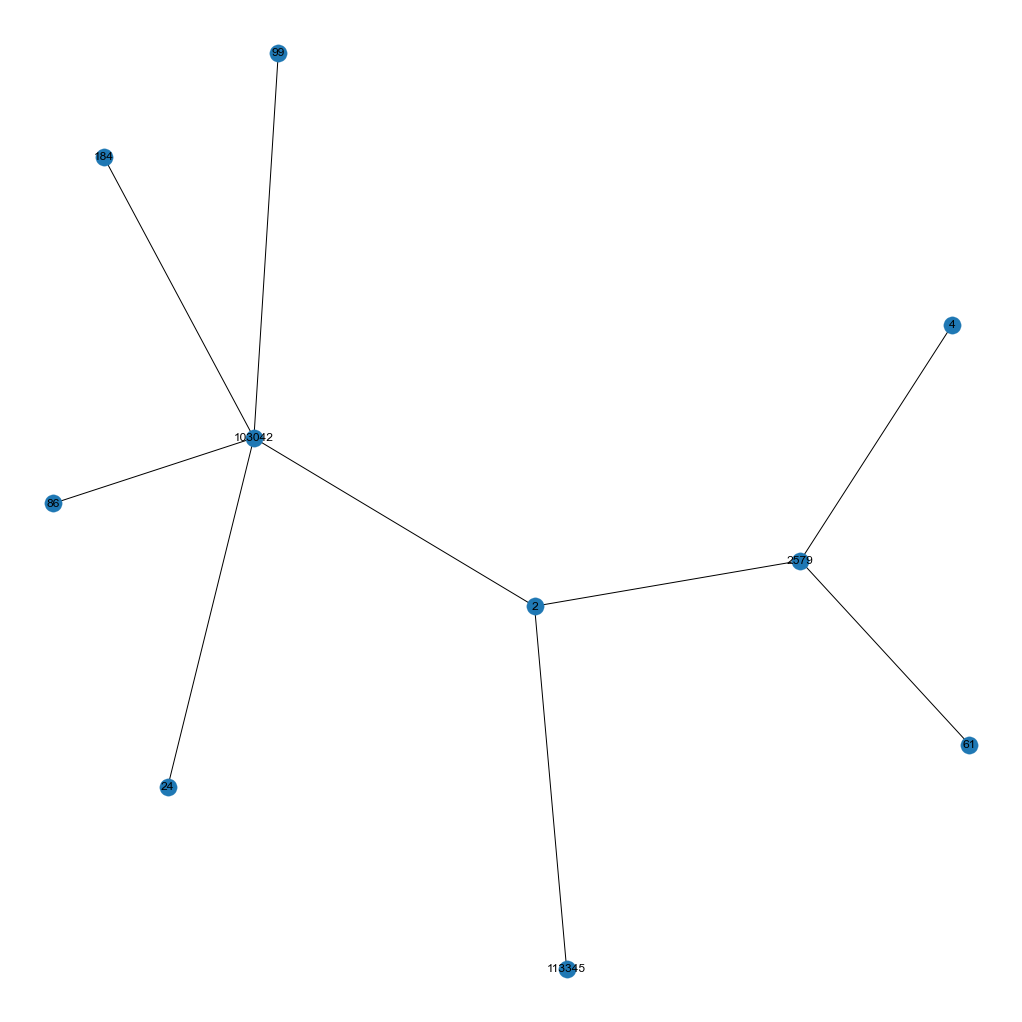

In [97]:
G = nx.from_pandas_edgelist(superman_jup_follow, 'userId', 'movieId', create_using=nx.Graph())

nx.draw(G, with_labels=True)

In [98]:
# Stats 
print(nx.info(G))

Name: 
Type: Graph
Number of nodes: 10
Number of edges: 9
Average degree:   1.8000


In [99]:
#Components, Reachability, and Path Length
ls_path = nx.shortest_path(G, 103042,2579)
print('The path length from {} to {} is {}.'.format('Superman','Following',len(ls_path)))
print('path length: ', ls_path)

The path length from Superman to Following is 3.
path length:  [103042, 2, 2579]


In [100]:
# degree_centrality = [(node,values) for (node, values) in nx.degree_centrality(G)]
dict_metrics = dict(nx.degree_centrality(G))
df_metrics = pd.DataFrame.from_dict(dict_metrics, orient='index')
df_metrics.columns=['degree_centrality']
df_metrics.index.name = 'userId'

In [101]:
df_metrics.sort_values('degree_centrality',ascending=False).head()

,degree_centrality
userId,
103042,0.555556
2,0.333333
2579,0.333333
24,0.111111
86,0.111111


In [102]:
dict_metrics = dict(nx.closeness_centrality(G))
df_metrics = pd.DataFrame.from_dict(dict_metrics, orient='index')
df_metrics.columns=['metrics']
df_metrics.index.name = 'userId'
df_metrics.sort_values('metrics',ascending=False).head()

,metrics
userId,
2,0.600000
103042,0.600000
2579,0.473684
24,0.391304
86,0.391304


In [103]:
dict_metrics = dict(nx.betweenness_centrality(G))
df_metrics = pd.DataFrame.from_dict(dict_metrics, orient='index')
df_metrics.columns=['metrics']
df_metrics.index.name = 'userId'
df_metrics.sort_values('metrics',ascending=False).head()

,metrics
userId,
103042,0.722222
2,0.638889
2579,0.416667
24,0.000000
86,0.000000


In [104]:
cliques = list(nx.find_cliques(G))
len(cliques)

9

In [105]:
import functools

In [106]:
num_cliques = len(cliques)
ls_len_cliques = [len(cliq) for cliq in cliques ]
max_clique_size = max(ls_len_cliques)
min_clique_size = min(ls_len_cliques)
avg_clique_size = np.mean(ls_len_cliques)
max_cliques = [c for c in cliques if len(c) == max_clique_size]
min_cliques = [c for c in cliques if len(c) == min_clique_size]
max_clique_sets = [set(c) for c in max_cliques]
min_clique_sets = [set(c) for c in min_cliques]
people_in_max_cliques = list(functools.reduce(lambda x,y: x.intersection(y), max_clique_sets))
people_in_min_cliques = list(functools.reduce(lambda x,y: x.intersection(y), min_clique_sets))

In [107]:
print(num_cliques)
print(max_clique_size)
print(min_clique_size)
print(avg_clique_size)

9
2
2
2.0


In [108]:
max_cliques

[[113345, 2],
 [103042, 2],
 [103042, 99],
 [103042, 86],
 [103042, 24],
 [103042, 184],
 [4, 2579],
 [2579, 2],
 [2579, 61]]

In [109]:
min_cliques

[[113345, 2],
 [103042, 2],
 [103042, 99],
 [103042, 86],
 [103042, 24],
 [103042, 184],
 [4, 2579],
 [2579, 2],
 [2579, 61]]

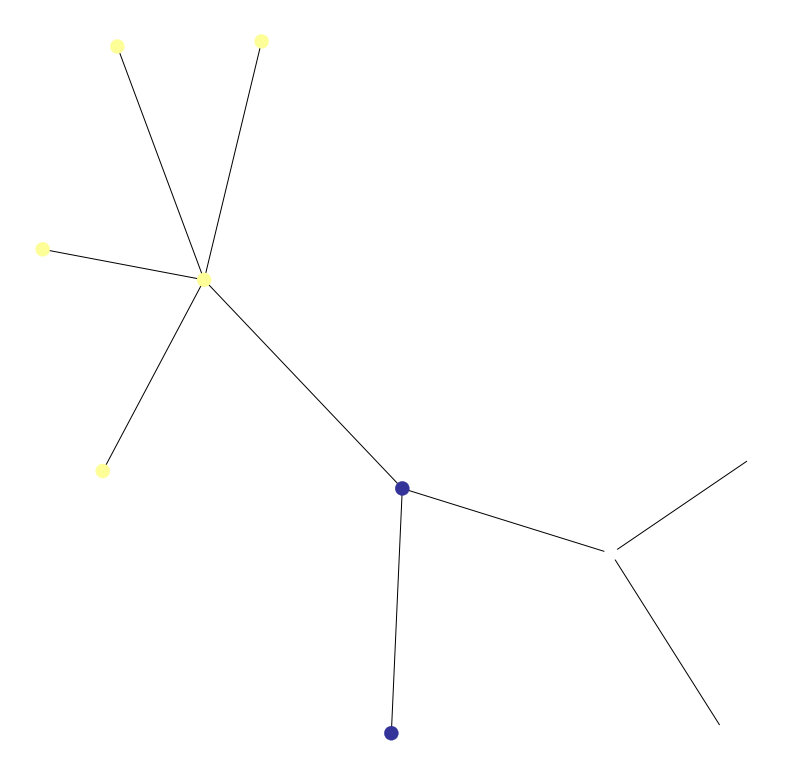

In [110]:
spring_pos = nx.spring_layout(G)
dict_clusters = community.best_partition(G,resolution=1.0)
clusters = [dict_clusters.get(node) for node in G.nodes()]
plt.axis("off")
nx.draw_networkx(G,
                 pos = spring_pos,
                 cmap = plt.get_cmap("terrain"),
                 node_color = clusters, 
                 node_size = 200,
                 with_labels = False
                 )

In [111]:
preds_jc = nx.jaccard_coefficient(G)

In [112]:
pred_jc_dict = {}
for u, v, p in preds_jc:
    pred_jc_dict[(u,v)] = p

In [113]:
sorted(pred_jc_dict.items(), key=lambda x:x[1], reverse=True)[:10]

[((99, 86), 1.0),
 ((99, 24), 1.0),
 ((99, 184), 1.0),
 ((4, 61), 1.0),
 ((86, 24), 1.0),
 ((86, 184), 1.0),
 ((24, 184), 1.0),
 ((113345, 2579), 0.3333333333333333),
 ((2, 99), 0.3333333333333333),
 ((2, 4), 0.3333333333333333)]

In [114]:
preds_pa = nx.preferential_attachment(G)
pred_pa_dict = {}
for u, v, p in preds_pa:
    pred_pa_dict[(u,v)] = p

In [115]:
sorted(pred_pa_dict.items(), key=lambda x:x[1], reverse=True)[:10]

[((103042, 2579), 15),
 ((113345, 103042), 5),
 ((103042, 4), 5),
 ((103042, 61), 5),
 ((113345, 2579), 3),
 ((2, 99), 3),
 ((2, 4), 3),
 ((2, 86), 3),
 ((2, 24), 3),
 ((2, 61), 3)]

In [116]:
nx.communicability(G)

{2: {2: 3.2527365824969223,
  103042: 2.5799293471955007,
  24: 0.8581428486408121,
  86: 0.858142848640812,
  99: 0.8581428486408123,
  184: 0.858142848640812,
  113345: 1.6428363841169027,
  2579: 2.0701950148010977,
  4: 0.7465662566038562,
  61: 0.7465662566038562},
 103042: {2: 2.5799293471955007,
  103042: 4.85744568774159,
  24: 2.0907889402286486,
  86: 2.090788940228649,
  99: 2.090788940228649,
  184: 2.090788940228649,
  113345: 0.8581428486408113,
  2579: 0.9697194406777669,
  4: 0.2548671661972014,
  61: 0.2548671661972014},
 24: {2: 0.8581428486408121,
  103042: 2.0907889402286486,
  24: 1.7498257097751946,
  86: 0.7498257097751942,
  99: 0.7498257097751944,
  184: 0.7498257097751946,
  113345: 0.23427324076964984,
  2579: 0.2548671661972024,
  4: 0.055788296018477734,
  61: 0.055788296018477734},
 86: {2: 0.858142848640812,
  103042: 2.090788940228649,
  24: 0.7498257097751942,
  86: 1.7498257097751955,
  99: 0.7498257097751941,
  184: 0.7498257097751944,
  113345: 0.234